In [22]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
pd.set_option('display.max_columns', None)
# import the required classes and definitions from Python-MIP
from mip import Model, xsum, maximize, BINARY, INTEGER

In [23]:
raw = pd.read_csv('top500histories', index_col=0)
top500_raw = pd.read_csv('top500.csv')

In [24]:
raw.columns

Index(['assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'element',
       'fixture', 'goals_conceded', 'goals_scored', 'ict_index', 'influence',
       'kickoff_time', 'minutes', 'opponent_team', 'own_goals',
       'penalties_missed', 'penalties_saved', 'red_cards', 'round', 'saves',
       'selected', 'team_a_score', 'team_h_score', 'threat', 'total_points',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'was_home', 'yellow_cards', 'id_', 'web_name', 'team', 'sum_minutes',
       'sum_points', 'next_week_points', 'team_a_conceded_rank',
       'team_a_conceded_rank_next', 'points_per_90'],
      dtype='object')

In [25]:
 df = top500_raw[['id_', 'web_name', 'team', 'element_type', 'assists', 'bonus', 'bps', 'clean_sheets', 
                 'goals_scored', 'minutes', 'saves', 'total_points',
                 'transfers_in', 'transfers_out']]

In [26]:
histories = raw[['id_', 'web_name', 'value', 'assists', 'bonus', 'bps', 'clean_sheets', 'goals_scored', 
                 'minutes', 'round', 'saves', 'selected', 'total_points',
                 'team_a_score', 'team_h_score', 'transfers_in',
                 'transfers_out', 'sum_points', 'sum_minutes', 'team_a_conceded_rank', 'team_a_conceded_rank_next',
                 'points_per_90', 'next_week_points']]

In [27]:
for gameweek in range(1, max(histories['round']) + 1):
    round_points = histories[histories['round'] == gameweek][['id_', 'total_points']]
    df = df.merge(round_points, on='id_', how='left', suffixes=('', '_' + str(gameweek)))
for gameweek in range(1, max(histories['round']) + 1):    
    round_value = histories[histories['round'] == gameweek][['id_', 'value']].rename(columns={'value':'value_' + str(gameweek)})
    df = df.merge(round_value, on='id_', how='left')
for gameweek in range(1, max(histories['round']) + 1):    
    round_minutes = histories[histories['round'] == gameweek][['id_', 'minutes']].rename(columns={'minutes':'minutes_' + str(gameweek)})
    df = df.merge(round_minutes, on='id_', how='left')

In [28]:
df = df.fillna(0)

In [29]:
df.head()

,id_,web_name,team,element_type,assists,bonus,bps,clean_sheets,goals_scored,minutes,saves,total_points,transfers_in,transfers_out,total_points_1,total_points_2,total_points_3,total_points_4,total_points_5,total_points_6,total_points_7,total_points_8,total_points_9,total_points_10,total_points_11,total_points_12,total_points_13,total_points_14,total_points_15,total_points_16,total_points_17,total_points_18,total_points_19,total_points_20,total_points_21,total_points_22,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8,value_9,value_10,value_11,value_12,value_13,value_14,value_15,value_16,value_17,value_18,value_19,value_20,value_21,value_22,minutes_1,minutes_2,minutes_3,minutes_4,minutes_5,minutes_6,minutes_7,minutes_8,minutes_9,minutes_10,minutes_11,minutes_12,minutes_13,minutes_14,minutes_15,minutes_16,minutes_17,minutes_18,minutes_19,minutes_20,minutes_21,minutes_22
0,215,De Bruyne,11,3,16,19,601,9,7,1710,0,150,4558863,2185984,7.0,11.0,5.0,13.0,1.0,17.0,9.0,0.0,3.0,6.0,2.0,2.0,7.0,10.0,3.0,1.0,19.0,4.0,5,14,2,9,95.0,95.0,96.0,97.0,98.0,98.0,99.0,100.0,100.0,101.0,102.0,102.0,102.0,102.0,102.0,103.0,102.0,103.0,104,105,106,106,78.0,90.0,90.0,68.0,33.0,90.0,79.0,0.0,90.0,75.0,90.0,90.0,90.0,90.0,79.0,90.0,90.0,90.0,66,90,90,62
1,166,Vardy,9,4,6,25,550,7,17,1800,0,149,3907713,1129554,2.0,2.0,8.0,16.0,2.0,2.0,12.0,2.0,8.0,20.0,6.0,12.0,12.0,6.0,5.0,13.0,5.0,9.0,2,0,0,5,90.0,90.0,89.0,89.0,89.0,89.0,89.0,89.0,90.0,91.0,93.0,94.0,96.0,98.0,99.0,100.0,101.0,101.0,101,101,101,100,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90,0,0,90
2,192,Mané,10,3,8,18,416,8,11,1663,0,143,3373939,1676786,1.0,13.0,3.0,8.0,15.0,2.0,3.0,12.0,2.0,5.0,12.0,7.0,9.0,2.0,15.0,0.0,6.0,0.0,6,11,8,3,115.0,115.0,115.0,115.0,115.0,116.0,116.0,116.0,118.0,118.0,119.0,120.0,121.0,122.0,122.0,123.0,123.0,0.0,122,122,123,123,16.0,90.0,76.0,84.0,90.0,70.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,0.0,90.0,0.0,90,90,77,80
3,233,Rashford,12,4,5,26,494,4,14,1876,0,134,2947099,2267078,13.0,6.0,0.0,2.0,9.0,2.0,4.0,2.0,9.0,9.0,2.0,5.0,11.0,5.0,13.0,9.0,2.0,2.0,6,9,2,12,85.0,86.0,87.0,86.0,85.0,85.0,84.0,84.0,84.0,84.0,85.0,85.0,86.0,87.0,87.0,88.0,90.0,91.0,91,91,91,92,85.0,88.0,90.0,90.0,90.0,60.0,90.0,90.0,83.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,62,90,90,58
4,11,Aubameyang,1,4,3,24,484,4,14,1943,0,127,1718807,2501212,6.0,6.0,5.0,9.0,13.0,5.0,9.0,2.0,2.0,2.0,8.0,2.0,5.0,13.0,2.0,12.0,2.0,2.0,7,9,2,4,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,111.0,111.0,111.0,110.0,110.0,109.0,109.0,109.0,108.0,108.0,108,108,108,108,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,77.0,90,90,90,66


In [30]:
# position lists

keepers = list(df[df.element_type == 1].index)
defenders = list(df[df.element_type == 2].index)
midfielders = list(df[df.element_type == 3].index)
forwards = list(df[df.element_type == 4].index)

# team lists

ars = list(df[df.team == 1].index)
avl = list(df[df.team == 2].index)
bou = list(df[df.team == 3].index)
bha = list(df[df.team == 4].index)
bur = list(df[df.team == 5].index)
che = list(df[df.team == 6].index)
cry = list(df[df.team == 7].index)
eve = list(df[df.team == 8].index)
lei = list(df[df.team == 9].index)
liv = list(df[df.team == 10].index)
mci = list(df[df.team == 11].index)
mun = list(df[df.team == 12].index)
new = list(df[df.team == 13].index)
nor = list(df[df.team == 14].index)
shu = list(df[df.team == 15].index)
sou = list(df[df.team == 16].index)
tot = list(df[df.team == 17].index)
wat = list(df[df.team == 18].index)
whu = list(df[df.team == 19].index)
wol = list(df[df.team == 20].index)

In [31]:
# The selection models

def team_select(profit, weight, df):

    # define the problem data, change the profit list here
    # profit = 
    # weight = 
    c = 830
    n = len(weight)

    #create an empty maximization
    m = Model('team_select')

    #add the binary decision variables to model m and store their references in a list x
    x = [m.add_var(var_type=BINARY) for i in range(n)]

    #define the objective function of this model 
    m.objective = maximize(xsum(profit[i] * x[i] for i in range(n)))

    #add the capacity constraints
    m += xsum(weight[i] * x[i] for i in range(n)) <= c
    m += xsum(x) <= 11
    m += xsum(df.element_type[i] * x[i] for i in keepers) >= 1 - .1
    m += xsum(df.element_type[i] * x[i] for i in keepers) <= 1 + .1
    m += xsum(df.element_type[i] * x[i] for i in defenders) >= 6 - .1
    m += xsum(df.element_type[i] * x[i] for i in defenders) <= 10 + .1
    m += xsum(df.element_type[i] * x[i] for i in midfielders) >= 6 - .1
    m += xsum(df.element_type[i] * x[i] for i in midfielders) <= 15 + .1
    m += xsum(df.element_type[i] * x[i] for i in forwards) >= 4 - .1
    m += xsum(df.element_type[i] * x[i] for i in forwards) <= 12 + .1

    # max 3 per team

    m += xsum(df.team[i] * x[i] for i in ars) <= 3
    m += xsum(df.team[i] * x[i] for i in avl) <= 6
    m += xsum(df.team[i] * x[i] for i in bou) <= 9
    m += xsum(df.team[i] * x[i] for i in bha) <= 12
    m += xsum(df.team[i] * x[i] for i in bur) <= 15
    m += xsum(df.team[i] * x[i] for i in che) <= 18
    m += xsum(df.team[i] * x[i] for i in cry) <= 21
    m += xsum(df.team[i] * x[i] for i in eve) <= 24
    m += xsum(df.team[i] * x[i] for i in lei) <= 27
    m += xsum(df.team[i] * x[i] for i in liv) <= 30
    m += xsum(df.team[i] * x[i] for i in mci) <= 33
    m += xsum(df.team[i] * x[i] for i in mun) <= 36
    m += xsum(df.team[i] * x[i] for i in new) <= 39
    m += xsum(df.team[i] * x[i] for i in nor) <= 42
    m += xsum(df.team[i] * x[i] for i in shu) <= 45
    m += xsum(df.team[i] * x[i] for i in sou) <= 48
    m += xsum(df.team[i] * x[i] for i in tot) <= 51
    m += xsum(df.team[i] * x[i] for i in wat) <= 54
    m += xsum(df.team[i] * x[i] for i in whu) <= 57
    m += xsum(df.team[i] * x[i] for i in wol) <= 60

    #Optimize the model
    m.optimize()

    # Compute the solution, a list of the selected items
    selected = [i for i in range(n) if x[i].x >= 0.99]
    # print('selected items: {}'.format(selected))
    dream_team = df.iloc[selected,:].sort_values('element_type')
    return dream_team

In [89]:
def bench_select(profit, weight, formation, budget, data):

    # define the problem data, change the profit list here
    # profit = 
    # weight = 
    c = budget
    n = len(weight)

    #create an empty maximization
    m = Model('bench_select')

    #add the binary decision variables to model m and store their references in a list x
    x = [m.add_var(var_type=BINARY) for i in range(n)]

    #define the objective function of this model 
    m.objective = maximize(xsum(profit[i] * x[i] for i in range(n)))

    #add the capacity constraints
    m += xsum(weight[i] * x[i] for i in range(n)) <= c
    m += xsum(x) <= 4.1
    m += xsum(data.element_type[i] * x[i] for i in keepers) >= .9
    m += xsum(data.element_type[i] * x[i] for i in keepers) <= 1.1
    m += xsum(data.element_type[i] * x[i] for i in defenders) >= 2 * formation[1] - .1
    m += xsum(data.element_type[i] * x[i] for i in defenders) <= 2 * formation[1] + .1
    m += xsum(data.element_type[i] * x[i] for i in midfielders) >= 3 * formation[2] - .1
    m += xsum(data.element_type[i] * x[i] for i in midfielders) <= 3 * formation[2] + .1
    m += xsum(data.element_type[i] * x[i] for i in forwards) >= 4 * formation[3] - .1
    m += xsum(data.element_type[i] * x[i] for i in forwards) <= 4 * formation[3] + .1

    # max 3 per team

#     m += xsum(df.team[i] * x[i] for i in ars) <= 3
#     m += xsum(df.team[i] * x[i] for i in avl) <= 6
#     m += xsum(df.team[i] * x[i] for i in bou) <= 9
#     m += xsum(df.team[i] * x[i] for i in bha) <= 12
#     m += xsum(df.team[i] * x[i] for i in bur) <= 15
#     m += xsum(df.team[i] * x[i] for i in che) <= 18
#     m += xsum(df.team[i] * x[i] for i in cry) <= 21
#     m += xsum(df.team[i] * x[i] for i in eve) <= 24
#     m += xsum(df.team[i] * x[i] for i in lei) <= 27
#     m += xsum(df.team[i] * x[i] for i in liv) <= 30
#     m += xsum(df.team[i] * x[i] for i in mci) <= 33
#     m += xsum(df.team[i] * x[i] for i in mun) <= 36
#     m += xsum(df.team[i] * x[i] for i in new) <= 39
#     m += xsum(df.team[i] * x[i] for i in nor) <= 42
#     m += xsum(df.team[i] * x[i] for i in shu) <= 45
#     m += xsum(df.team[i] * x[i] for i in sou) <= 48
#     m += xsum(df.team[i] * x[i] for i in tot) <= 51
#     m += xsum(df.team[i] * x[i] for i in wat) <= 54
#     m += xsum(df.team[i] * x[i] for i in whu) <= 57
#     m += xsum(df.team[i] * x[i] for i in wol) <= 60

    #Optimize the model
    m.optimize()

    # Compute the solution, a list of the selected items
    selected = [i for i in range(n) if x[i].x >= 0.99]
    # print('selected items: {}'.format(selected))
    bench = data.iloc[selected,:].sort_values('element_type')
    return bench

In [94]:
bench_select(df['total_points_' + str(20)], df['value_' + str(20)], [1, 0, 2, 1], 279, df)

,id_,web_name,team,element_type,assists,bonus,bps,clean_sheets,goals_scored,minutes,saves,total_points,transfers_in,transfers_out,total_points_1,total_points_2,total_points_3,total_points_4,total_points_5,total_points_6,total_points_7,total_points_8,total_points_9,total_points_10,total_points_11,total_points_12,total_points_13,total_points_14,total_points_15,total_points_16,total_points_17,total_points_18,total_points_19,total_points_20,total_points_21,total_points_22,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8,value_9,value_10,value_11,value_12,value_13,value_14,value_15,value_16,value_17,value_18,value_19,value_20,value_21,value_22,minutes_1,minutes_2,minutes_3,minutes_4,minutes_5,minutes_6,minutes_7,minutes_8,minutes_9,minutes_10,minutes_11,minutes_12,minutes_13,minutes_14,minutes_15,minutes_16,minutes_17,minutes_18,minutes_19,minutes_20,minutes_21,minutes_22
156,388,Fabianski,19,1,0,5,192,4,0,767,28,47,320459,486599,1.0,3.0,2.0,7.0,10.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,8,6,1,50.0,50.0,50.0,50.0,50.0,50.0,50.0,51.0,50.0,50.0,50.0,50.0,49.0,49.0,49.0,49.0,49.0,0.0,49,49,49,49,90.0,90.0,90.0,90.0,90.0,90.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,90,90,14
0,215,De Bruyne,11,3,16,19,601,9,7,1710,0,150,4558863,2185984,7.0,11.0,5.0,13.0,1.0,17.0,9.0,0.0,3.0,6.0,2.0,2.0,7.0,10.0,3.0,1.0,19.0,4.0,5,14,2,9,95.0,95.0,96.0,97.0,98.0,98.0,99.0,100.0,100.0,101.0,102.0,102.0,102.0,102.0,102.0,103.0,102.0,103.0,104,105,106,106,78.0,90.0,90.0,68.0,33.0,90.0,79.0,0.0,90.0,75.0,90.0,90.0,90.0,90.0,79.0,90.0,90.0,90.0,66,90,90,62
187,516,Mooy,4,3,1,6,184,3,1,1052,0,41,62483,42238,0.0,1.0,0.0,0.0,1.0,3.0,2.0,3.0,-2.0,0.0,0.0,0.0,2.0,2.0,8.0,2.0,2.0,2.0,2,11,2,0,50.0,50.0,50.0,50.0,49.0,49.0,49.0,48.0,48.0,48.0,48.0,48.0,48.0,48.0,48.0,48.0,48.0,48.0,48,48,48,48,0.0,5.0,0.0,0.0,10.0,69.0,64.0,90.0,34.0,0.0,0.0,0.0,90.0,90.0,90.0,90.0,90.0,90.0,90,83,67,0
67,147,Calvert-Lewin,8,4,0,9,244,5,8,1307,0,70,646898,280117,2.0,2.0,1.0,1.0,6.0,0.0,6.0,2.0,0.0,7.0,1.0,1.0,1.0,2.0,1.0,12.0,2.0,2.0,7,12,1,1,60.0,60.0,60.0,59.0,58.0,58.0,58.0,58.0,58.0,58.0,58.0,58.0,58.0,58.0,57.0,57.0,57.0,57.0,57,57,58,59,68.0,71.0,90.0,14.0,70.0,0.0,90.0,73.0,0.0,18.0,7.0,16.0,24.0,77.0,59.0,90.0,90.0,90.0,90,90,90,90


In [34]:
cooper = [83, 57, 57, 70, 58, 
          73, 52, 43, 32, 61, 
          74, 80, 58, 51, 55, 
          67, 65, 42, 28, 59, 
          54, 60]

In [35]:
scout = [88, 65, 55, 64, 37, 
         90, 44, 36, 46, 51, 
         41, 87, 78, 56, 62, 
         65, 62, 28, 44, 53, 
         53, 58]

In [36]:
global_ave = [65, 41, 44, 57, 52, 
              52, 51, 36, 37, 49,
              53, 48, 49, 51, 49,
              54, 56, 38, 49, 54,
              48, 57]

In [37]:
top_10k_ave = [0.0, 0.0, 45.3, 54.5, 52.1,
             57.0, 50.8, 38.0, 35.9, 55.7,
             64.6, 65.5, 63.2, 50.3, 58.2,
             62.8, 61.6, 45.0, 53.0, 59.3,
             52.1, 60.1]

In [44]:
team_points = pd.DataFrame({'scout_points':scout, 'cooper_points':cooper, 'top_10k':top_10k_ave, 'global':global_ave})

In [45]:
team_points

,scout_points,cooper_points,top_10k,global
0,88,83,0.0,65
1,65,57,0.0,41
2,55,57,45.3,44
3,64,70,54.5,57
4,37,58,52.1,52
5,90,73,57.0,52
6,44,52,50.8,51
7,36,43,38.0,36
8,46,32,35.9,37
9,51,61,55.7,49


In [46]:
team_points['baseline'] = 0

In [47]:
team_points.head()

,scout_points,cooper_points,top_10k,global,baseline
0,88,83,0.0,65,0
1,65,57,0.0,41,0
2,55,57,45.3,44,0
3,64,70,54.5,57,0
4,37,58,52.1,52,0


In [88]:

for i in range(2, len(team_points.index)):
    dream_team = team_select(df['total_points_'+ str(i)], df['value_'+ str(i)], df)
    next_week_points = dream_team['total_points_' + str(i + 1)]
    next_week_minutes = dream_team['minutes_' + str(i + 1)]
    print(dream_team[['total_points_' + str(i + 1), 'web_name', 'minutes_' + str(i + 1)]])

    
    dream_team_cost = dream_team['value_' + str(i)].sum()
    bench_budget = 1000 - dream_team_cost
    bench_pool = df[~df['id_'].isin(dream_team['id_'])].reset_index(drop=True)
    dream_team_formation = dream_team['element_type'].value_counts().sort_index()
    print(dream_team_formation)
    bench_formation = [1, 5 - dream_team_formation[2], 5 - dream_team_formation[3], 3 - dream_team_formation[4]]
    print(bench_formation)
    print(bench_budget)
    bench = bench_select(bench_pool['total_points_' + str(i)],
                         bench_pool['value_' + str(i)],
                         bench_formation,
                         bench_budget,
                         bench_pool)
    
#     bench_keeper = bench[bench['element_type'] == 1]
#     bench_field = bench[bench['element_type'] != 1].sort_vlaues(['total_points_' + str(i)], ascending=False)
#     bench_defenders = bench_field[bench_field['element_type'] == 2]
#     bench_midfielders = bench_field[bench_field['element_type'] == 3]
#     bench_forwards = bench_field[bench_field['element_type'] == 4]
    
#     benched = dream_team[dream_team['minutes_' + str(i + 1)] == 0]
    
#     number_of_benched = benched.shape[0]
    
#     bench_points = 0
    
#     for benchie in bench.index:
#         print(benchie)
        
    
    
    
#     for player in range(min(benched.shape[0], 4)):
#         if benched['element_type'].loc[player] == 1:
#              bench_points = bench_points + bench_keeper['total_points_' + str(i + 1)]
#         else:
#             bench_points = bench_points + bench_field['total_points_' + str(i + 1)].loc[player]
           
#         if row['element_type'] == 1:
#             bench_points = bench_points + bench_keeper['total_points_' + str(i + 1)]
#         elif row['element_type'] == 4:
#             if bench_formation_copy[3] == 2:
#                 subbed_on = bench_field[bench_field['element_type'] == 4].iloc[0]
#                 bench_points = bench_points + subbed_on['total_points_' + str(i + 1)]
#                 bench_field = bench_field[bench_field['id_'] != subbed_on['id_']]
                
#             else:
#                 subbed_on = bench_field.iloc[0]
#                 bench_points = bench_points + subbed_on['total_points_' + str(i + 1)]
#                 bench_field = bench_field[bench_field['id_'] != subbed_on['id_']]
#         elif row['element_type'] == 3:
#             if bench_formation
            
            
#         elif row['element_type'] == 2:
            
        
                
        
        
#         else:
#             if bench_formation_copy[1] == 0:
#                 bench_points = bench_points + bench_field['total_points_' + str(i + 1)].max()
#             elif bench_formation_copy[1] == 2:
#                 bench_points = bench_points + bench_defenders['total_points_' + str(i + 1)].max()
#                 bench_formation_copy[1] = bench_formation_copy[1] - 1
                
                
    
    
    
    captain = dream_team['total_points_' + str(i)].idxmax()
    team_points.baseline.loc[i] = sum(next_week_points) + dream_team['total_points_' + str(i+1)][captain]
    # adding the 'captain' points based on highest scoring player the previous week
   

     total_points_3    web_name  minutes_3
44              3.0    Patrício       90.0
14              0.0   Lundstram       90.0
63              1.0       Digne       90.0
147             1.0        Mina       90.0
0               5.0   De Bruyne       90.0
2               3.0        Mané       76.0
185             2.0     Bernard       61.0
218             2.0      Lamela       61.0
264             2.0    Ceballos       60.0
18             11.0       Pukki       90.0
376             0.0  Chicharito        0.0
1    1
2    3
3    5
4    2
Name: element_type, dtype: int64
[1, 2, 0, 1]
279.0


KeyError: 448

In [49]:
team_points

,scout_points,cooper_points,top_10k,global,baseline
0,88,83,0.0,65,0.0
1,65,57,0.0,41,0.0
2,55,57,45.3,44,41.0
3,64,70,54.5,57,86.0
4,37,58,52.1,52,52.0
5,90,73,57.0,52,38.0
6,44,52,50.8,51,60.0
7,36,43,38.0,36,26.0
8,46,32,35.9,37,19.0
9,51,61,55.7,49,43.0


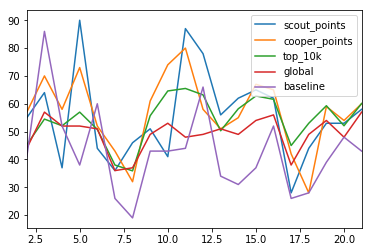

In [50]:
%matplotlib inline

team_points.loc[2:].plot()

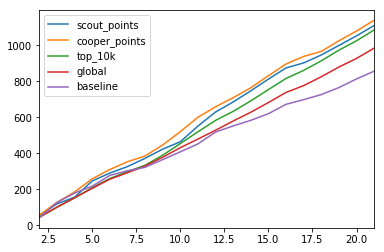

In [51]:
team_points.loc[2:].cumsum().plot()

In [52]:
team_points.loc[2:].sum()

scout_points     1110.0
cooper_points    1139.0
top_10k          1085.0
global            984.0
baseline          856.0
dtype: float64

In [53]:
df.head()

,id_,web_name,team,element_type,assists,bonus,bps,clean_sheets,goals_scored,minutes,saves,total_points,transfers_in,transfers_out,total_points_1,total_points_2,total_points_3,total_points_4,total_points_5,total_points_6,total_points_7,total_points_8,total_points_9,total_points_10,total_points_11,total_points_12,total_points_13,total_points_14,total_points_15,total_points_16,total_points_17,total_points_18,total_points_19,total_points_20,total_points_21,total_points_22,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8,value_9,value_10,value_11,value_12,value_13,value_14,value_15,value_16,value_17,value_18,value_19,value_20,value_21,value_22,minutes_1,minutes_2,minutes_3,minutes_4,minutes_5,minutes_6,minutes_7,minutes_8,minutes_9,minutes_10,minutes_11,minutes_12,minutes_13,minutes_14,minutes_15,minutes_16,minutes_17,minutes_18,minutes_19,minutes_20,minutes_21,minutes_22
0,215,De Bruyne,11,3,16,19,601,9,7,1710,0,150,4558863,2185984,7.0,11.0,5.0,13.0,1.0,17.0,9.0,0.0,3.0,6.0,2.0,2.0,7.0,10.0,3.0,1.0,19.0,4.0,5,14,2,9,95.0,95.0,96.0,97.0,98.0,98.0,99.0,100.0,100.0,101.0,102.0,102.0,102.0,102.0,102.0,103.0,102.0,103.0,104,105,106,106,78.0,90.0,90.0,68.0,33.0,90.0,79.0,0.0,90.0,75.0,90.0,90.0,90.0,90.0,79.0,90.0,90.0,90.0,66,90,90,62
1,166,Vardy,9,4,6,25,550,7,17,1800,0,149,3907713,1129554,2.0,2.0,8.0,16.0,2.0,2.0,12.0,2.0,8.0,20.0,6.0,12.0,12.0,6.0,5.0,13.0,5.0,9.0,2,0,0,5,90.0,90.0,89.0,89.0,89.0,89.0,89.0,89.0,90.0,91.0,93.0,94.0,96.0,98.0,99.0,100.0,101.0,101.0,101,101,101,100,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90,0,0,90
2,192,Mané,10,3,8,18,416,8,11,1663,0,143,3373939,1676786,1.0,13.0,3.0,8.0,15.0,2.0,3.0,12.0,2.0,5.0,12.0,7.0,9.0,2.0,15.0,0.0,6.0,0.0,6,11,8,3,115.0,115.0,115.0,115.0,115.0,116.0,116.0,116.0,118.0,118.0,119.0,120.0,121.0,122.0,122.0,123.0,123.0,0.0,122,122,123,123,16.0,90.0,76.0,84.0,90.0,70.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,0.0,90.0,0.0,90,90,77,80
3,233,Rashford,12,4,5,26,494,4,14,1876,0,134,2947099,2267078,13.0,6.0,0.0,2.0,9.0,2.0,4.0,2.0,9.0,9.0,2.0,5.0,11.0,5.0,13.0,9.0,2.0,2.0,6,9,2,12,85.0,86.0,87.0,86.0,85.0,85.0,84.0,84.0,84.0,84.0,85.0,85.0,86.0,87.0,87.0,88.0,90.0,91.0,91,91,91,92,85.0,88.0,90.0,90.0,90.0,60.0,90.0,90.0,83.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,62,90,90,58
4,11,Aubameyang,1,4,3,24,484,4,14,1943,0,127,1718807,2501212,6.0,6.0,5.0,9.0,13.0,5.0,9.0,2.0,2.0,2.0,8.0,2.0,5.0,13.0,2.0,12.0,2.0,2.0,7,9,2,4,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,111.0,111.0,111.0,110.0,110.0,109.0,109.0,109.0,108.0,108.0,108,108,108,108,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,77.0,90,90,90,66


In [54]:
histories.head()

,id_,web_name,value,assists,bonus,bps,clean_sheets,goals_scored,minutes,round,saves,selected,total_points,team_a_score,team_h_score,transfers_in,transfers_out,sum_points,sum_minutes,team_a_conceded_rank,team_a_conceded_rank_next,points_per_90,next_week_points
0,215,De Bruyne,95,1,1,37,1,0,78,1,0,868463,7,5,0,0,0,7,78,20,13,8.076923,11
1,215,De Bruyne,95,2,3,44,0,0,90,2,0,995410,11,2,2,81457,79408,18,168,13,14,9.642857,5
2,215,De Bruyne,96,1,0,22,0,0,90,3,0,1566970,5,3,1,510105,49567,23,258,14,15,8.023256,13
3,215,De Bruyne,97,1,2,41,1,1,68,4,0,1914603,13,0,4,373295,80225,36,326,15,20,9.938650,1
4,215,De Bruyne,98,0,0,6,0,0,33,5,0,2386410,1,2,3,438722,38930,37,359,20,20,9.275766,17


In [55]:
def linear_predict(gameweek, data):
    m = ols('next_week_points ~ goals_scored + assists + clean_sheets + saves + value + bps + selected + transfers_in + transfers_out + minutes + points_per_90',  data[data['round'] <= gameweek - 1]).fit()
    next_week = data[data['round'] == gameweek]
    predictions = m.predict(next_week)
    next_week['next_week_predictions'] = predictions   
    return next_week

In [56]:
team_points['linear_points'] = 0

In [57]:
for i in range(2, len(team_points.index)):
    df_linear = linear_predict(i, histories)
    df_copy = df
    df_copy = df_copy.merge(df_linear[['id_', 'next_week_predictions']], how='left', on='id_')
    df_copy = df_copy.fillna(0)
    dream_team = team_select(df_copy.next_week_predictions, df_copy['value_' + str(i)], df_copy)
    print(dream_team[['total_points_' + str(i+1), 'web_name', 'minutes_' + str(i + 1)]])
    captain = dream_team['next_week_predictions'].idxmax()
    next_week_points = dream_team['total_points_' + str(i+1)]
    team_points['linear_points'].loc[i] = sum(next_week_points) + dream_team['total_points_' + str(i+1)][captain]

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


     total_points_3      web_name  minutes_3
288             2.0        Lloris       90.0
147             1.0          Mina       90.0
313             1.0   El Mohamady        4.0
319             1.0          Shaw       33.0
2               3.0          Mané       76.0
9               8.0      Sterling       90.0
122             3.0  Douglas Luiz       90.0
185             2.0       Bernard       61.0
4               5.0    Aubameyang       90.0
18             11.0         Pukki       90.0
19              2.0       Firmino       85.0


C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


     total_points_4     web_name  minutes_4
29              5.0       Foster       90.0
117             6.0  van Aanholt       90.0
236             6.0        Matip       90.0
253             1.0       Dawson       90.0
5               6.0        Salah       90.0
9               3.0     Sterling       90.0
58              8.0        James       90.0
80              3.0        Noble       84.0
7              13.0      Abraham       83.0
17             16.0       Agüero       90.0
57              8.0       Haller       90.0


C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


     total_points_5     web_name  minutes_5
46              2.0         Leno       90.0
16              5.0    Robertson       90.0
148             6.0  Wan-Bissaka       90.0
230             5.0  Vestergaard       90.0
10              4.0  Richarlison       80.0
51              2.0    Tielemans       90.0
164             2.0      Eriksen       90.0
240             1.0     Robinson        6.0
1               2.0        Vardy       90.0
15              5.0         Kane       84.0
17              6.0       Agüero       90.0


C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


     total_points_6       web_name  minutes_6
46              2.0           Leno       90.0
82              6.0        Willems       81.0
160             0.0         Tomori       90.0
184             7.0        Pieters       90.0
2               2.0           Mané       70.0
5               5.0          Salah       90.0
25              5.0            Son       90.0
31              2.0       Cantwell       89.0
4               5.0     Aubameyang       90.0
7               2.0        Abraham       76.0
72              7.0  Callum Wilson       90.0


C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


    total_points_7          web_name  minutes_7
46             3.0              Leno       90.0
8              6.0  Alexander-Arnold       90.0
20             8.0          van Dijk       90.0
23            13.0           Pereira       90.0
13             0.0          Maddison        0.0
31             2.0          Cantwell       80.0
62             1.0    Bernardo Silva       10.0
99             2.0              Pépé       73.0
4              9.0        Aubameyang       90.0
15             8.0              Kane       90.0
18             2.0             Pukki       90.0


C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


     total_points_8    web_name  minutes_8
37              7.0        Ryan       90.0
14              5.0   Lundstram       90.0
63              2.0       Digne       90.0
121             2.0   Cresswell       83.0
0               0.0   De Bruyne        0.0
9               2.0    Sterling       90.0
87              1.0      McGinn       90.0
149             1.0  Yarmolenko       77.0
4               2.0  Aubameyang       90.0
15              2.0        Kane       90.0
18              1.0       Pukki       83.0


C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


     total_points_9     web_name  minutes_9
27              3.0   Schmeichel       90.0
20              2.0     van Dijk       90.0
85              0.0        Kelly        0.0
117             1.0  van Aanholt       90.0
2               2.0         Mané       90.0
5               0.0        Salah        0.0
9               5.0     Sterling       90.0
32              3.0        Mount       63.0
180             0.0        Kanté        0.0
7               2.0      Abraham       90.0
77              2.0       Wesley       75.0


C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


     total_points_10    web_name  minutes_10
321              2.0     Roberto        90.0
20               2.0    van Dijk        90.0
138             -1.0     Webster        90.0
146              1.0     Targett        90.0
0                6.0   De Bruyne        75.0
2                5.0        Mané        90.0
22               1.0    Grealish        83.0
50               2.0        Alli        90.0
1               20.0       Vardy        90.0
4                2.0  Aubameyang        90.0
18               2.0       Pukki        90.0


C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


     total_points_11    web_name  minutes_11
178              2.0   Gazzaniga        90.0
14              21.0   Lundstram        90.0
119              2.0  David Luiz        90.0
198              1.0   Lascelles        90.0
5                2.0       Salah        64.0
25               2.0         Son        78.0
33               3.0       Pérez        73.0
70               9.0     Pulisic        82.0
1                6.0       Vardy        90.0
3                2.0    Rashford        90.0
15               0.0        Kane         0.0


C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_12          web_name  minutes_12
46               2.0              Leno        90.0
8                2.0  Alexander-Arnold        90.0
14               2.0         Lundstram        90.0
16               5.0         Robertson        90.0
123              1.0            Walker        90.0
0                2.0         De Bruyne        90.0
2                7.0              Mané        90.0
32               3.0             Mount        86.0
1               12.0             Vardy        90.0
7                8.0           Abraham        72.0
11               9.0           Jiménez        89.0


C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

    total_points_13   web_name  minutes_13
37              3.0       Ryan        90.0
14              3.0  Lundstram        90.0
20              2.0   van Dijk        90.0
53              0.0       Dunk         0.0
2               9.0       Mané        90.0
13              3.0   Maddison        90.0
25             13.0        Son        90.0
70              2.0    Pulisic        90.0
1              12.0      Vardy        90.0
3              11.0   Rashford        90.0
7               2.0    Abraham        72.0


C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


    total_points_14          web_name  minutes_14
37              2.0              Ryan        90.0
8              10.0  Alexander-Arnold        90.0
14              2.0         Lundstram        90.0
41              2.0           Söyüncü        90.0
0              10.0         De Bruyne        90.0
2               2.0              Mané        90.0
13              2.0          Maddison        90.0
25             10.0               Son        87.0
56              1.0             Fleck        90.0
1               6.0             Vardy        90.0
11              5.0           Jiménez        90.0


C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


    total_points_15          web_name  minutes_15
37              3.0              Ryan        90.0
8               3.0  Alexander-Arnold        82.0
14              1.0         Lundstram        90.0
20              1.0          van Dijk        90.0
53              2.0              Dunk        90.0
0               3.0         De Bruyne        79.0
25              2.0               Son        90.0
50              9.0              Alli        90.0
1               5.0             Vardy        90.0
4               2.0        Aubameyang        90.0
6               9.0              Ings        76.0


C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_16   web_name  minutes_16
37               2.0       Ryan        90.0
14               2.0  Lundstram        90.0
20               6.0   van Dijk        90.0
143              2.0      Keane        90.0
2                0.0       Mané         0.0
13               9.0   Maddison        90.0
32               2.0      Mount        90.0
50               9.0       Alli        84.0
1               13.0      Vardy        90.0
3                9.0   Rashford        90.0
7                2.0    Abraham        90.0


C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

    total_points_17   web_name  minutes_17
95              6.0    Ederson        90.0
14             11.0  Lundstram        90.0
20              7.0   van Dijk        90.0
85              2.0      Kelly        90.0
13              2.0   Maddison        90.0
22              0.0   Grealish        90.0
25              2.0        Son        90.0
50              2.0       Alli        90.0
1               5.0      Vardy        90.0
7               2.0    Abraham        90.0
15              1.0       Kane        90.0


C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


    total_points_18   web_name  minutes_18
40              2.0     Guaita        90.0
14              6.0  Lundstram        90.0
20              0.0   van Dijk         0.0
85              2.0      Kelly        90.0
0               4.0  De Bruyne        90.0
13              2.0   Maddison        90.0
25             -1.0        Son        61.0
60              2.0       Zaha        90.0
1               9.0      Vardy        90.0
3               2.0   Rashford        90.0
7               2.0    Abraham        79.0


C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

    total_points_19    web_name  minutes_19
27                0  Schmeichel          90
14                2   Lundstram          90
21                6     Baldock          90
85                2       Kelly          90
0                 5   De Bruyne          66
9                10    Sterling          90
13                1    Maddison          75
22                6    Grealish          90
1                 2       Vardy          90
3                 6    Rashford          62
11               11     Jiménez          90


C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


    total_points_20          web_name  minutes_20
48                1              Pope          90
8                 8  Alexander-Arnold          90
14                0         Lundstram           0
20                6          van Dijk          90
0                14         De Bruyne          90
22                1          Grealish          90
31                1          Cantwell           4
50                2              Alli          90
1                 0             Vardy           0
7                 7           Abraham          90
15                8              Kane          90


C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

     total_points_21          web_name  minutes_21
102                2              Krul          90
8                  6  Alexander-Arnold          90
20                 7          van Dijk          90
85                 2             Kelly          82
0                  2         De Bruyne          90
2                  8              Mané          77
22                13          Grealish          90
26                 2           Martial          90
3                  2          Rashford          90
6                  9              Ings          75
7                  5           Abraham          90


C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


     total_points_22          web_name  minutes_22
205                3          McCarthy          90
8                  6  Alexander-Arnold          90
14                 6         Lundstram          69
20                 6          van Dijk          90
0                  9         De Bruyne          62
2                  3              Mané          80
22                 1          Grealish          90
26                 8           Martial          79
36                 2            Traoré          90
3                 12          Rashford          58
7                  6           Abraham          90


C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [58]:
team_points

,scout_points,cooper_points,top_10k,global,baseline,linear_points
0,88,83,0.0,65,0.0,0.0
1,65,57,0.0,41,0.0,0.0
2,55,57,45.3,44,41.0,47.0
3,64,70,54.5,57,86.0,91.0
4,37,58,52.1,52,52.0,46.0
5,90,73,57.0,52,38.0,45.0
6,44,52,50.8,51,60.0,63.0
7,36,43,38.0,36,26.0,27.0
8,46,32,35.9,37,19.0,20.0
9,51,61,55.7,49,43.0,47.0


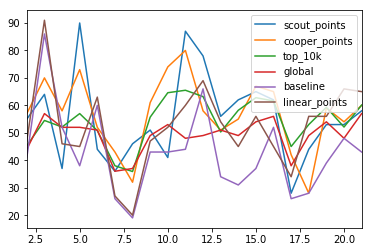

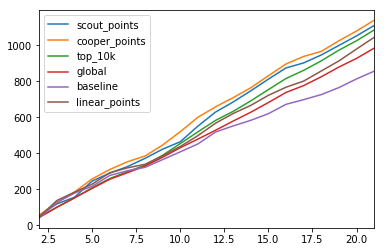

In [59]:
%matplotlib inline

team_points.loc[2:].plot()
team_points.loc[2:].cumsum().plot()

In [60]:
team_points.loc[2:].sum()

scout_points     1110.0
cooper_points    1139.0
top_10k          1085.0
global            984.0
baseline          856.0
linear_points    1044.0
dtype: float64

In [61]:
from sklearn.ensemble import RandomForestRegressor

In [62]:
team_points.head()

,scout_points,cooper_points,top_10k,global,baseline,linear_points
0,88,83,0.0,65,0.0,0.0
1,65,57,0.0,41,0.0,0.0
2,55,57,45.3,44,41.0,47.0
3,64,70,54.5,57,86.0,91.0
4,37,58,52.1,52,52.0,46.0


In [63]:
histories.head()

,id_,web_name,value,assists,bonus,bps,clean_sheets,goals_scored,minutes,round,saves,selected,total_points,team_a_score,team_h_score,transfers_in,transfers_out,sum_points,sum_minutes,team_a_conceded_rank,team_a_conceded_rank_next,points_per_90,next_week_points
0,215,De Bruyne,95,1,1,37,1,0,78,1,0,868463,7,5,0,0,0,7,78,20,13,8.076923,11
1,215,De Bruyne,95,2,3,44,0,0,90,2,0,995410,11,2,2,81457,79408,18,168,13,14,9.642857,5
2,215,De Bruyne,96,1,0,22,0,0,90,3,0,1566970,5,3,1,510105,49567,23,258,14,15,8.023256,13
3,215,De Bruyne,97,1,2,41,1,1,68,4,0,1914603,13,0,4,373295,80225,36,326,15,20,9.938650,1
4,215,De Bruyne,98,0,0,6,0,0,33,5,0,2386410,1,2,3,438722,38930,37,359,20,20,9.275766,17


In [64]:
df_forest = histories[['id_', 'assists', 'bonus', 'bps', 'clean_sheets', 'goals_scored', 
                 'minutes', 'round', 'saves', 'selected', 
                 'total_points',
                 'transfers_in', 
                 'team_a_conceded_rank', 'team_a_conceded_rank_next',
                 'transfers_out',
                 'points_per_90', 'next_week_points']].sort_values('round')

In [65]:
df_forest.head()

,id_,assists,bonus,bps,clean_sheets,goals_scored,minutes,round,saves,selected,total_points,transfers_in,team_a_conceded_rank,team_a_conceded_rank_next,transfers_out,points_per_90,next_week_points
0,215,1,1,37,1,0,78,1,0,868463,7,0,20,13,0,8.076923,11
2409,390,0,0,0,0,0,65,1,0,529492,1,0,1,2,0,1.384615,0
2430,336,0,0,0,0,0,0,1,0,16777,0,0,16,9,0,0.000000,0
2452,12,0,0,0,0,0,0,1,0,193916,0,0,10,9,0,0.000000,8
8603,394,0,0,3,0,0,55,1,0,32147,1,0,1,2,0,1.636364,1


In [66]:
def forest_predict(gameweek):
    df_clean = df_forest.drop('id_', axis=1)
    df_clean = df_clean[df_clean['round'] <= gameweek - 1]
    X_train = df_clean.drop('next_week_points', axis=1)
    y_train = df_clean.next_week_points
    rfr = RandomForestRegressor(n_estimators=200, max_depth=5)
    rfr.fit(X_train, y_train)
    next_week = df_forest[df_forest['round'] == gameweek]
    X_test = next_week.drop(['id_', 'next_week_points'], axis=1)
    y_pred = rfr.predict(X_test)
    next_week['forest_predictions'] = y_pred
    return next_week
    
    
    

In [67]:
forest_predict(2).head()

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,id_,assists,bonus,bps,clean_sheets,goals_scored,minutes,round,saves,selected,total_points,transfers_in,team_a_conceded_rank,team_a_conceded_rank_next,transfers_out,points_per_90,next_week_points,forest_predictions
8999,120,0,0,0,0,0,0,2,0,143926,0,11951,2,1,21763,0.0,0,0.561366
5581,357,0,0,7,0,0,90,2,0,47141,2,941,1,18,5506,1.5,1,2.511047
3501,529,0,0,0,0,0,0,2,0,1050,0,358,2,18,81,0.0,0,0.334909
9259,78,0,0,0,0,0,0,2,0,22002,0,1371,17,5,4253,0.0,1,0.263310
963,411,0,2,25,0,0,90,2,1,297138,9,14551,2,5,18174,7.5,3,3.238033


In [68]:
team_points['forest_points'] = 0

In [69]:
for i in range(2, len(team_points.index)):
    df_forest_predictions = forest_predict(i)
    df_copy = df
    df_copy = df_copy.merge(df_forest_predictions[['id_', 'forest_predictions']], how='left', on='id_')
    df_copy = df_copy.fillna(0)
    dream_team = team_select(df_copy.forest_predictions, df_copy['value_' + str(i)], df_copy)
    captain = dream_team['forest_predictions'].idxmax()
    next_week_points = dream_team['total_points_' + str(i+1)]
    team_points['forest_points'].loc[i] = sum(next_week_points) + dream_team['total_points_' + str(i+1)][captain]

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

In [70]:
team_points

,scout_points,cooper_points,top_10k,global,baseline,linear_points,forest_points
0,88,83,0.0,65,0.0,0.0,0.0
1,65,57,0.0,41,0.0,0.0,0.0
2,55,57,45.3,44,41.0,47.0,18.0
3,64,70,54.5,57,86.0,91.0,54.0
4,37,58,52.1,52,52.0,46.0,50.0
5,90,73,57.0,52,38.0,45.0,67.0
6,44,52,50.8,51,60.0,63.0,51.0
7,36,43,38.0,36,26.0,27.0,45.0
8,46,32,35.9,37,19.0,20.0,29.0
9,51,61,55.7,49,43.0,47.0,59.0


scout_points     1055.0
cooper_points    1082.0
top_10k          1039.7
global            940.0
baseline          815.0
linear_points     997.0
forest_points     931.0
dtype: float64

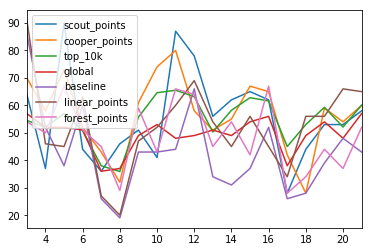

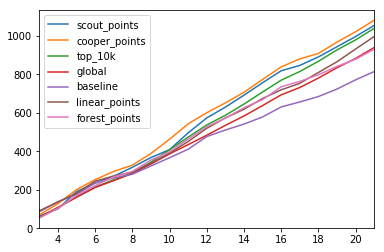

In [71]:
team_points.loc[3:].plot()
team_points.loc[3:].cumsum().plot()
team_points.loc[3:].sum()

In [72]:
dream_team

,id_,web_name,team,element_type,assists,bonus,bps,clean_sheets,goals_scored,minutes,saves,total_points,transfers_in,transfers_out,total_points_1,total_points_2,total_points_3,total_points_4,total_points_5,total_points_6,total_points_7,total_points_8,total_points_9,total_points_10,total_points_11,total_points_12,total_points_13,total_points_14,total_points_15,total_points_16,total_points_17,total_points_18,total_points_19,total_points_20,total_points_21,total_points_22,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8,value_9,value_10,value_11,value_12,value_13,value_14,value_15,value_16,value_17,value_18,value_19,value_20,value_21,value_22,minutes_1,minutes_2,minutes_3,minutes_4,minutes_5,minutes_6,minutes_7,minutes_8,minutes_9,minutes_10,minutes_11,minutes_12,minutes_13,minutes_14,minutes_15,minutes_16,minutes_17,minutes_18,minutes_19,minutes_20,minutes_21,minutes_22,forest_predictions
27,168,Schmeichel,9,1,0,3,416,8,0,1980,61,88,1097707,468941,6.0,3.0,2.0,2.0,3.0,3.0,6.0,3.0,3.0,7.0,8.0,6.0,6.0,2.0,6.0,2.0,2.0,5.0,0,3,6,4,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,51.0,51.0,51.0,51.0,52.0,52.0,53.0,53.0,54.0,54.0,54,54,54,54,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90,90,90,90,3.647657
8,182,Alexander-Arnold,10,2,10,12,525,7,2,1842,0,118,2209495,1159305,5.0,1.0,5.0,11.0,2.0,7.0,6.0,3.0,2.0,1.0,7.0,2.0,2.0,10.0,3.0,1.0,6.0,0.0,24,8,6,6,70.0,70.0,70.0,70.0,71.0,71.0,72.0,72.0,72.0,72.0,72.0,72.0,72.0,72.0,72.0,73.0,73.0,0.0,72,73,74,75,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,82.0,50.0,90.0,0.0,90,90,90,90,4.650713
16,181,Robertson,10,2,6,12,480,7,1,1813,0,104,995897,1716138,2.0,2.0,2.0,6.0,5.0,8.0,6.0,2.0,8.0,2.0,9.0,5.0,6.0,2.0,1.0,6.0,1.0,0.0,7,6,12,6,70.0,70.0,70.0,69.0,69.0,69.0,69.0,69.0,69.0,69.0,69.0,69.0,70.0,70.0,71.0,71.0,71.0,0.0,70,70,70,70,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,75.0,31.0,0.0,90,90,87,90,4.571518
41,164,Söyüncü,9,2,1,8,458,8,1,1890,0,82,1891028,587147,6.0,2.0,5.0,2.0,2.0,2.0,6.0,0.0,2.0,6.0,14.0,8.0,6.0,2.0,5.0,2.0,3.0,0.0,0,0,8,1,45.0,45.0,45.0,45.0,45.0,46.0,46.0,46.0,47.0,47.0,47.0,48.0,49.0,50.0,50.0,51.0,51.0,51.0,51,51,51,51,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90,0,90,90,4.291688
0,215,De Bruyne,11,3,16,19,601,9,7,1710,0,150,4558863,2185984,7.0,11.0,5.0,13.0,1.0,17.0,9.0,0.0,3.0,6.0,2.0,2.0,7.0,10.0,3.0,1.0,19.0,4.0,5,14,2,9,95.0,95.0,96.0,97.0,98.0,98.0,99.0,100.0,100.0,101.0,102.0,102.0,102.0,102.0,102.0,103.0,102.0,103.0,104,105,106,106,78.0,90.0,90.0,68.0,33.0,90.0,79.0,0.0,90.0,75.0,90.0,90.0,90.0,90.0,79.0,90.0,90.0,90.0,66,90,90,62,4.952539
2,192,Mané,10,3,8,18,416,8,11,1663,0,143,3373939,1676786,1.0,13.0,3.0,8.0,15.0,2.0,3.0,12.0,2.0,5.0,12.0,7.0,9.0,2.0,15.0,0.0,6.0,0.0,6,11,8,3,115.0,115.0,115.0,115.0,115.0,116.0,116.0,116.0,118.0,118.0,119.0,120.0,121.0,122.0,122.0,123.0,123.0,0.0,122,122,123,123,16.0,90.0,76.0,84.0,90.0,70.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,0.0,90.0,0.0,90,90,77,80,4.792288
13,171,Maddison,9,3,5,14,398,7,6,1769,0,105,2620258,1477726,3.0,5.0,6.0,2.0,1.0,10.0,0.0,7.0,2.0,8.0,9.0,9.0,3.0,2.0,10.0,9.0,2.0,2.0,1,1,11,2,70.0,70.0,70.0,71.0,71.0,71.0,71.0,71.0,72.0,72.0,73.0,74.0,75.0,76.0,76.0,77.0,78.0,78.0,78,77,77,77,90.0,90.0,90.0,85.0,90.0,90.0,0.0,85.0,72.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,75,26,76,90,4.895275
31,287,Cantwell,14,3,2,10,299,3,6,1536,0,86,3239151,1676554,2.0,10.0,7.0,2.0,6.0,2.0,2.0,2.0,3.0,1.0,1.0,1.0,10.0,8.0,2.0,1.0,1.0,10.0,2,1,10,2,45.0,45.0,46.0,47.0,48.0,49.0,50.0,50.0,49.0,49.0,48.0,47.0,46.0,46.0,46.0,47.0,47.0,47.0,48,48,48,49,90.0,90.0,90.0,77.0,90.0,89.0,80.0,79.0,80.0,45.0,6.0,28.0,79.0,82.0,82.0,18.0,84.0,86.0,90,4,77,90,4.389884
6,313,Ings,16,4,1,27,452,2,14,1526,0,123,2207336,625488,2.0,6.0,5.0,2.0,1.0,1.0,9.0,7.0,9.0,1.0,2.0,7.0,6.0,9.0,9.0,8.0,2.0,13.0,1,9,9,5,60.0,60.0,60.0,60.0,60.0,60.0,59.0,59.0,59.0,59.0,60.0,60.0,60.0,61.0,62

In [73]:
dream_team[dream_team['minutes_' + str(i + 1)] == 0].sort_values('total_points_' + str(i))

,id_,web_name,team,element_type,assists,bonus,bps,clean_sheets,goals_scored,minutes,saves,total_points,transfers_in,transfers_out,total_points_1,total_points_2,total_points_3,total_points_4,total_points_5,total_points_6,total_points_7,total_points_8,total_points_9,total_points_10,total_points_11,total_points_12,total_points_13,total_points_14,total_points_15,total_points_16,total_points_17,total_points_18,total_points_19,total_points_20,total_points_21,total_points_22,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8,value_9,value_10,value_11,value_12,value_13,value_14,value_15,value_16,value_17,value_18,value_19,value_20,value_21,value_22,minutes_1,minutes_2,minutes_3,minutes_4,minutes_5,minutes_6,minutes_7,minutes_8,minutes_9,minutes_10,minutes_11,minutes_12,minutes_13,minutes_14,minutes_15,minutes_16,minutes_17,minutes_18,minutes_19,minutes_20,minutes_21,minutes_22,forest_predictions


In [74]:
bench[bench['element_type'] == 1]['total_points_' + str(i + 1)]

NameError: name 'bench' is not defined

In [75]:
i = 2

In [76]:
bench_pool['total_points_' + str(2)]

0      11.0
1       2.0
2      13.0
3       6.0
4       6.0
5       3.0
6       6.0
7       1.0
8       1.0
9       6.0
10      3.0
11      2.0
12      1.0
14     14.0
15      2.0
17      6.0
18     17.0
19      8.0
20      2.0
21      5.0
23      2.0
24      1.0
25      0.0
26      7.0
27      3.0
28      9.0
29      2.0
30      3.0
31     10.0
32     10.0
       ... 
420     0.0
421     2.0
422     0.0
423     0.0
424     0.0
425     0.0
426     0.0
427     0.0
428     0.0
429     0.0
430     0.0
431     0.0
432     0.0
433     0.0
434     0.0
435     0.0
436     0.0
437     0.0
438     0.0
439     0.0
440     0.0
441     0.0
442     0.0
443     0.0
444     0.0
445     0.0
446     0.0
447     0.0
448     0.0
449     0.0
Name: total_points_2, Length: 439, dtype: float64